In [2]:
#Importing packages
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense, Activation, Dropout, RepeatVector
from tensorflow.keras.optimizers import  RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [6]:
#Loading the data
path = '1661-0.txt'
text = open(path,encoding = "utf8").read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [7]:
#Data Preprocessing
character = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(character))
indices_char = dict((i, c) for i, c in enumerate(character))
 
print(f'unique chars: {len(character)}')

unique chars: 73


In [8]:
#chunk 40 characters with 3 sequences
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len ])
    next_chars.append(text[i + seq_len])
print(f'num training examples: {len(sentences)}')

num training examples: 193950


In [9]:
# generating our features and labels
#one hot encoding
X = np.zeros((len(sentences), seq_len, len(character)), dtype=np.bool)
y = np.zeros((len(sentences), len(character)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

sentences[124]
next_chars[100]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


'e'

In [10]:
#one hot encoded data
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [11]:
#one hot encoded data
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [12]:
X.shape

(193950, 40, 73)

In [13]:
y.shape

(193950, 73)

In [14]:
# Creating the model
model = Sequential()
model.add(LSTM(128, input_shape=(seq_len, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               103424    
                                                                 
 dense (Dense)               (None, 73)                9417      
                                                                 
 activation (Activation)     (None, 73)                0         
                                                                 
Total params: 112,841
Trainable params: 112,841
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Training our model
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y,
                    validation_split=0.01, 
                    batch_size=128,
                    epochs=7, 
                    shuffle=True).history

Epoch 1/7
1501/1501 [==============================] - 199s 131ms/step - loss: 1.9428 - accuracy: 0.4283 - val_loss: 2.1991 - val_accuracy: 0.3979
Epoch 2/7
1501/1501 [==============================] - 191s 127ms/step - loss: 1.6089 - accuracy: 0.5182 - val_loss: 2.0704 - val_accuracy: 0.4515
Epoch 3/7
1501/1501 [==============================] - 190s 126ms/step - loss: 1.5159 - accuracy: 0.5425 - val_loss: 1.9946 - val_accuracy: 0.4665
Epoch 4/7
1501/1501 [==============================] - 190s 127ms/step - loss: 1.4664 - accuracy: 0.5576 - val_loss: 1.9774 - val_accuracy: 0.4711
Epoch 5/7
1501/1501 [==============================] - 195s 130ms/step - loss: 1.4351 - accuracy: 0.5660 - val_loss: 2.0068 - val_accuracy: 0.4613
Epoch 6/7
1501/1501 [==============================] - 190s 127ms/step - loss: 1.4111 - accuracy: 0.5719 - val_loss: 1.9882 - val_accuracy: 0.4732
Epoch 7/7
1501/1501 [==============================] - 194s 129ms/step - loss: 1.3926 - accuracy: 0.5774 - val_loss: 2

In [20]:
#loading our model
model = load_model('NW_keras_model.h5')
history = pickle.load(open("history.p", "rb"))

In [21]:
#Model Evaluation
loss_and_acc=model.evaluate(X,y)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

6061/6061 [==============================] - 103s 17ms/step - loss: 1.3228 - accuracy: 0.5964
Test Loss 1.3227909803390503
Test Accuracy 0.5963547229766846


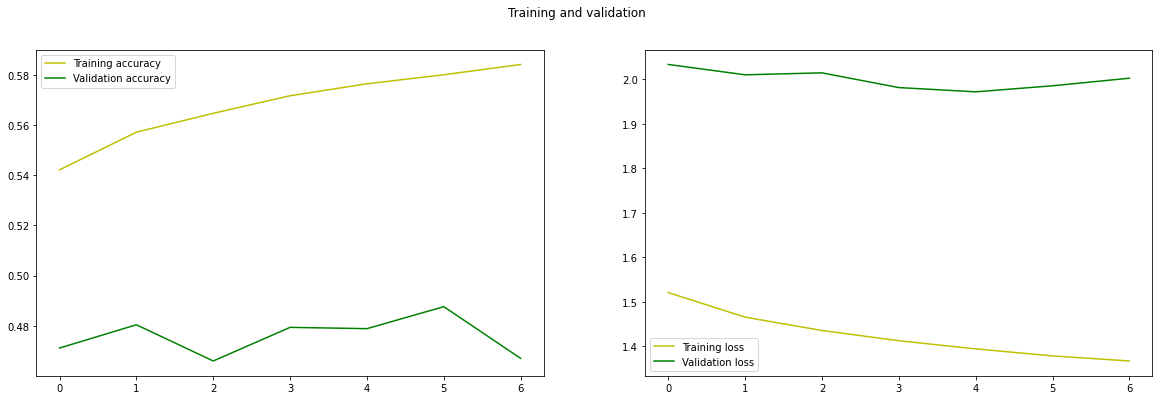

In [22]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'g', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'g', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()


In [23]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(character)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

prepare_input("This is an example of input of our model".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [24]:
#functions to get next probable characters
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [25]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [26]:
#Prediction
quotes = [   
    "Deep learning is subset of machine learning,which is essentially a neural network with three or more layers.",
    "Machine learning  is the study of computer algorithms that improve automatically through experience and by the use of data.",
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "Recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data.",
    "Thanks for spending your precious time to view my work."  
    
]
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

deep learning is subset of machine learn
[' a ', 'ed ', ', ', 'g ', 'ing ']

machine learning  is the study of comput
['ing ', 'e ', 'heres ', 'y. ', 's. ']

it is not a lack of love, but a lack of 
['the ', 'a ', 'her ', 'considerable ', 'men ']

recurrent neural network (rnn) is a type
['whow ', ' the ', 'hant ', '\nholmes ', 'le ']

thanks for spending your precious time t
['he ', 'o ', 'ell ', 'ime ', 'wo ']

